# Hybrid Book Recommendation System

Initiate Pyspark

In [1]:
# To initiate PySPark in Jupyter Notebook
import findspark
findspark.init()

findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

# Import Libraries

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext, types
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator , ParamGridBuilder
from pyspark.sql.functions import col
import numpy as np
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
import pandas as pd

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# Read and Print Schema

In [3]:
# Reading and Printing Schema for Ratings.csv

spark = SparkSession.builder.master('local').appName('brsals').getOrCreate()
ratings_df = spark.read.csv('ratings.csv', header = True, inferSchema = True)
ratings_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



# Display top 5 rows

In [4]:
# Displaying top 5 rows of Ratings.csv

ratings_df.show(5)

+---+-------+------+
| id|user_id|rating|
+---+-------+------+
|  1|    314|     5|
|  1|    439|     3|
|  1|    588|     5|
|  1|   1169|     4|
|  1|   1185|     4|
+---+-------+------+
only showing top 5 rows



Read and Print Schema for books.csv

In [5]:
# Reading and Printing Schema for books.csv

books_df = spark.read.csv('books.csv', header = True, inferSchema = True)
books_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


Display top 2 rows of books.csv

In [6]:
# Displaying top 2 rows of books.csv

books_df.show(2)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

# Alternating Least Squares

Splitting data into Training and Testing

In [7]:
training_df , validation_df = ratings_df.randomSplit([0.8 , 0.2])

In [8]:
iterations = 10
regularization_parameter = 0.1 #lambda
rank = 4
errors = []
err = 0

# Training ALS Model

In [11]:
# Training ALS Model

als = ALS(maxIter = iterations , regParam = regularization_parameter , rank = 4 , userCol = "user_id" , itemCol= "id",
         ratingCol = "rating")
model = als.fit(training_df)
predictions = model.transform(validation_df)
new_predictions = predictions.filter(col('prediction') !=np.nan)
evaluator = RegressionEvaluator(metricName = "rmse" , labelCol = "rating" , predictionCol = "prediction")
rmse = evaluator.evaluate(new_predictions)
print("Root Mean Square Error Value = " +str(rmse))

Root Mean Square Error Value = 0.8955888873339468


# Root Mean Square Error

In [12]:
# Finding different RMSE Rank value for ALS Model

for rank in range(4,6):
    als = ALS(maxIter = iterations , regParam = regularization_parameter , rank = rank , userCol = "user_id" , itemCol= "id",
         ratingCol = "rating")
    modeli = als.fit(training_df)
    predictions = modeli.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') !=np.nan)
    evaluator = RegressionEvaluator(metricName = "rmse" , labelCol = "rating" , predictionCol = "prediction")
    rmse = evaluator.evaluate(new_predictions)
    print("Rank : " ,rank , " Root Mean Square Error Value = " +str(rmse))

Rank :  4  Root Mean Square Error Value = 0.8955888873339468
Rank :  5  Root Mean Square Error Value = 0.9008007108599035


In [13]:
predictions = model.transform(validation_df)
predictions.show(n=2)

+---+-------+------+----------+
| id|user_id|rating|prediction|
+---+-------+------+----------+
|148|  20467|     3| 2.9313886|
|148|    588|     4| 3.2716587|
+---+-------+------+----------+
only showing top 2 rows



In [14]:
predictions.join(books_df , "id").select("user_id" , "title" , "prediction").show(2)

+-------+--------------------+----------+
|user_id|               title|prediction|
+-------+--------------------+----------+
|  20467|Girl with a Pearl...| 2.9313886|
|    588|Girl with a Pearl...| 3.2716587|
+-------+--------------------+----------+
only showing top 2 rows



In [15]:
for_one_user = predictions.filter(col("user_id") == 35982).join(books_df , "id").select("user_id" , "title" , "image_url" , "prediction")
for_one_user.count()

33

In [16]:
for_one_user.show()

+-------+--------------------+--------------------+----------+
|user_id|               title|           image_url|prediction|
+-------+--------------------+--------------------+----------+
|  35982|The Farthest Shor...|https://s.gr-asse...| 3.5523796|
|  35982|   A Little Princess|https://images.gr...| 3.8358064|
|  35982|Eragon (The Inher...|https://images.gr...| 2.7382224|
|  35982|Dune (Dune Chroni...|https://images.gr...|  3.870625|
|  35982|The Goose Girl (T...|https://images.gr...| 3.0788803|
|  35982|Alanna: The First...|https://s.gr-asse...| 3.5028934|
|  35982|The No. 1 Ladies'...|https://images.gr...| 3.1786587|
|  35982|   Wide Sargasso Sea|https://images.gr...|  3.516743|
|  35982|Island of the Blu...|https://images.gr...|  3.775589|
|  35982|Anna and the Fren...|https://images.gr...| 2.4385295|
|  35982|We Have Always Li...|https://images.gr...|   4.11443|
|  35982|Sir Gawain and th...|https://images.gr...| 3.3239255|
|  35982|     Never Let Me Go|https://images.gr...| 3.5

In [17]:
for book in for_one_user.take(5):
    print(book.title)
    display(Image(url=book.image_url))

The Farthest Shore (Earthsea Cycle, #3)


A Little Princess


Eragon (The Inheritance Cycle, #1)


Dune (Dune Chronicles #1)


The Goose Girl (The Books of Bayern, #1)


Generate top 2 recommendations

In [18]:
#Generate top 2 recommendations for each user

userRecomments = model.recommendForAllUsers(2)

Show 10 users with 2 recommended books

In [19]:
# Showing 10 users with 2 recommended books each

userRecomments.select("user_id" , "recommendations.id").show(10, False)

+-------+------------+
|user_id|id          |
+-------+------------+
|148    |[5207, 3491]|
|463    |[7762, 6590]|
|471    |[3836, 8606]|
|496    |[2681, 9461]|
|833    |[4868, 3885]|
|1088   |[9479, 3953]|
|1238   |[4868, 4]   |
|1342   |[4, 4336]   |
|1580   |[6590, 5207]|
|1591   |[6590, 3920]|
+-------+------------+
only showing top 10 rows



# Schema for recommendation

In [20]:
#Schema for recommendation

userRecomments.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



# Taking input for user id

In [21]:
# Instead of generating recommendation for all the users we are taking input as user id from the user

name_id = int(input("Enter your ID:"))
u_id = {'User_id':[name_id]}
u_id = pd.DataFrame(u_id)
users = spark.createDataFrame(u_id)
users.show()

Enter your ID:314
+-------+
|User_id|
+-------+
|    314|
+-------+



# Generate Recommendation for one user

In [22]:
usersSubsetRecs = model.recommendForUserSubset( users , 20)
#Now we will generate recommendation for above 1 user_id , for that we will use api recommendForUserSubset
userrecommend = usersSubsetRecs.select("user_id","recommendations")
userrecommend.show()
# Recommendations: List contains list of (book_id and predicted rating value) for all 20 books

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    314|[{5207, 4.522235}...|
+-------+--------------------+



# Recommended book id

In [23]:
# id are recommended book id by ALS Model

rateexplode = userrecommend.select('*').toPandas()
finalrecommend = rateexplode.explode('recommendations')
finalrecommend[['id','rate_prediction']] = pd.DataFrame(finalrecommend['recommendations'].tolist(), index=finalrecommend.index)
print(finalrecommend)

   user_id             recommendations    id  rate_prediction
0      314   (5207, 4.522234916687012)  5207         4.522235
0      314   (6590, 4.479695796966553)  6590         4.479696
0      314  (9566, 4.4620537757873535)  9566         4.462054
0      314   (6920, 4.458487510681152)  6920         4.458488
0      314   (1788, 4.440154552459717)  1788         4.440155
0      314   (7254, 4.406615257263184)  7254         4.406615
0      314   (862, 4.4056901931762695)   862         4.405690
0      314   (4483, 4.395471096038818)  4483         4.395471
0      314   (3628, 4.379123687744141)  3628         4.379124
0      314  (8978, 4.3494648933410645)  8978         4.349465
0      314  (8109, 4.3411173820495605)  8109         4.341117
0      314   (780, 4.3392133712768555)   780         4.339213
0      314   (5580, 4.308488845825195)  5580         4.308489
0      314   (6361, 4.305248737335205)  6361         4.305249
0      314   (3660, 4.293968200683594)  3660         4.293968
0      3

Converting into dataframes

In [24]:
# Converting the above ALS Prediction list into DataFrames

book_output = spark.createDataFrame(finalrecommend)
book_output = book_output.select('user_id','id','rate_prediction')
book_output.show()

+-------+----+------------------+
|user_id|  id|   rate_prediction|
+-------+----+------------------+
|    314|5207| 4.522234916687012|
|    314|6590| 4.479695796966553|
|    314|9566|4.4620537757873535|
|    314|6920| 4.458487510681152|
|    314|1788| 4.440154552459717|
|    314|7254| 4.406615257263184|
|    314| 862|4.4056901931762695|
|    314|4483| 4.395471096038818|
|    314|3628| 4.379123687744141|
|    314|8978|4.3494648933410645|
|    314|8109|4.3411173820495605|
|    314| 780|4.3392133712768555|
|    314|5580| 4.308488845825195|
|    314|6361| 4.305248737335205|
|    314|3660| 4.293968200683594|
|    314|9842| 4.291225910186768|
|    314|2244| 4.283778190612793|
|    314|4708| 4.283614158630371|
|    314|1029| 4.279642105102539|
|    314|2767|  4.27631950378418|
+-------+----+------------------+



# K Means Algorithm

In [25]:
#Reading and displaying books.csv for KMeans Algorithm

bks_df = spark.read.csv('books.csv', header = True, inferSchema = True)
bks_df.show(2)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

# Converting String value columns to integer value for vectorizations

In [26]:
# Converting String value columns to integer value for vectorizations

bks_df = bks_df.withColumn('isbn', bks_df['isbn'].cast(IntegerType()))
bks_df = bks_df.withColumn('average_rating', bks_df['average_rating'].cast(IntegerType()))
bks_df = bks_df.withColumn('ratings_count', bks_df['ratings_count'].cast(IntegerType()))
bks_df = bks_df.withColumn('work_ratings_count', bks_df['work_ratings_count'].cast(IntegerType()))
bks_df = bks_df.withColumn('work_text_reviews_count', bks_df['work_text_reviews_count'].cast(IntegerType()))

# Imputer Function

In [27]:
# Using Imputer function to fill in missing values for all the rows with mean, median or mode value

imputer = Imputer(inputCols = ['id','books_count','isbn','original_publication_year','average_rating','ratings_count',
                               'work_ratings_count','work_text_reviews_count','ratings_1','ratings_2','ratings_3','ratings_4',
                              'ratings_5'], outputCols = ['id','books_count','isbn','original_publication_year','average_rating','ratings_count',
                               'work_ratings_count','work_text_reviews_count','ratings_1','ratings_2','ratings_3','ratings_4',
                              'ratings_5'])
model1 = imputer.fit(bks_df)
bks_df = model1.transform(bks_df)
bks_df = bks_df.na.drop()
bks_df.show(5)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

# Using VectorAssembler

In [28]:
# Creating features column with all the features required to make clusters

assemble1 = VectorAssembler(inputCols = [
    'books_count',
    'isbn',
    'original_publication_year',
    'average_rating',
    'ratings_count',
    'work_ratings_count',
    'work_text_reviews_count',
    'ratings_1',
    'ratings_2',
    'ratings_3',
    'ratings_4',
    'ratings_5'
], outputCol = 'features')
assembled_data1 = assemble1.transform(bks_df)
assembled_data1.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: integer (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: integer (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- work_ratings_count: integer (nullable = true)
 |-- work_text_reviews_count: integer (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = t

# Creating scalar feature column

In [29]:
# Creating scalar feature column of the above vector column

scale = StandardScaler(inputCol='features', outputCol='standardized')
bks_scale = scale.fit(assembled_data1)
data_scale_output = bks_scale.transform(assembled_data1)
data_scale_output.show(5)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|            features|        standardized|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+----------

# Evaluating KMeans Model and finding the Silhouette Value

In [30]:
# Evaluating KMeans Model and finding the Silhouette Value for cluster 2 to 15

silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'standardized', metricName = 'silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    print('Silhouette Score:', score)

Silhouette Score: 0.11803074658832566
Silhouette Score: 0.8635095366463877
Silhouette Score: 0.8815924534834311
Silhouette Score: 0.8592574174024322
Silhouette Score: 0.4764971586768468
Silhouette Score: 0.5292255395002855
Silhouette Score: 0.4469370371865887
Silhouette Score: 0.6426357376428591
Silhouette Score: 0.674586042279129
Silhouette Score: 0.6772179945418042
Silhouette Score: 0.6983765276423608
Silhouette Score: 0.5131231726273495
Silhouette Score: 0.6828488695160545


# Plotting the Silhouette Value

Text(0, 0.5, 'score')

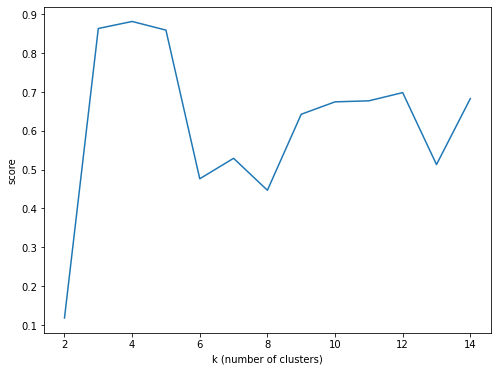

In [31]:
# Plotting the Silhouette Value for finding the best cluster k

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('k (number of clusters)')
ax.set_ylabel('score')

# Finding the Centroid Value of all the clusters

In [34]:
# Finding the Centroid Value of all the clusters
kmeans = KMeans().setK(5).setSeed(1)
kmodel = kmeans.fit(data_scale_output)
pred = kmodel.transform(data_scale_output)
eva = ClusteringEvaluator()
print('Cluster Centres:')
ctr=[]
centres = kmodel.clusterCenters()
for cen in centres:
    ctr.append(cen)
    print(cen)

Cluster Centres:
[7.98330192e+01 6.90713143e+08 1.98027855e+03 3.55032039e+00
 5.38999171e+04 5.94385028e+04 2.71159065e+03 1.26498235e+03
 3.00245722e+03 1.12459129e+04 1.98466732e+04 2.40607173e+04]
[1.26287938e+02 8.63482760e+07 1.94614786e+03 3.44980545e+00
 6.80096988e+04 7.48577774e+04 3.27594553e+03 1.83320700e+03
 4.36500233e+03 1.53953518e+04 2.51720965e+04 2.80921198e+04]
[7.72815272e+01 3.87870511e+08 1.99036134e+03 3.49865021e+00
 7.08911203e+04 7.79330879e+04 3.55135326e+03 1.78387312e+03
 4.01357694e+03 1.48778338e+04 2.61300231e+04 3.11277809e+04]
[8.49312169e+01 1.87008981e+09 1.98701058e+03 3.54497354e+00
 3.88432222e+04 4.53963280e+04 2.37377778e+03 1.06204762e+03
 2.48775661e+03 9.11477778e+03 1.56521852e+04 1.70795608e+04]
[5.35462520e+01 1.47267913e+09 1.99548005e+03 3.57097289e+00
 4.98188317e+04 5.54939769e+04 3.63077831e+03 1.28493222e+03
 2.81215152e+03 1.01477775e+04 1.84102504e+04 2.28388652e+04]


# Finding Silhouette Score for Bisecting KMeans ALgorithm

In [33]:
# Finding Silhouette Score for Bisecting KMeans ALgorithm

from pyspark.ml.clustering import BisectingKMeans

bisecting_silhouette_score = []
evaluator1 = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'standardized', metricName = 'silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):
    KMeans_algo1 = BisectingKMeans(featuresCol='standardized', k=i)
    KMeans_fit1 = KMeans_algo1.fit(data_scale_output)
    output1 = KMeans_fit1.transform(data_scale_output)
    score1 = evaluator1.evaluate(output1)
    bisecting_silhouette_score.append(score1)
    print('Silhouette Score:', score1)

Silhouette Score: 0.9738611248616339
Silhouette Score: 0.48744856258705593
Silhouette Score: 0.49519635242141286
Silhouette Score: 0.42093811750445814
Silhouette Score: 0.5826892373119313
Silhouette Score: 0.5815500171588199
Silhouette Score: 0.5825769137053829
Silhouette Score: 0.4033741525738341
Silhouette Score: 0.37125947591554115
Silhouette Score: 0.40338064677699104
Silhouette Score: 0.41910025961561925
Silhouette Score: 0.40568879937786406
Silhouette Score: 0.4065804547272518


Text(0, 0.5, 'score')

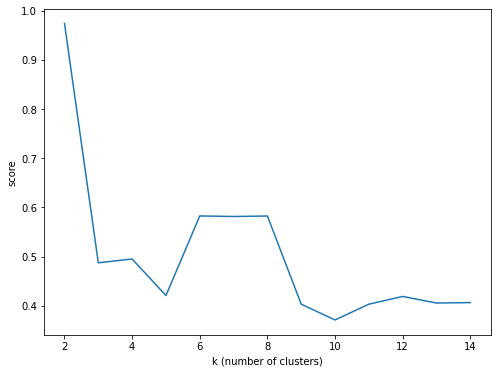

In [37]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),bisecting_silhouette_score)
ax.set_xlabel('k (number of clusters)')
ax.set_ylabel('score')

In [38]:
kmeans1 = KMeans().setK(6).setSeed(1)
model111 = kmeans1.fit(data_scale_output)
pred1 = model111.transform(data_scale_output)
eva1 = ClusteringEvaluator()
print('Cluster Centres:')
ctr1=[]
centres1 = model111.clusterCenters()
for cen1 in centres1:
    ctr1.append(cen1)
    print(cen1)

Cluster Centres:
[5.35462520e+01 1.47267913e+09 1.99548005e+03 3.57097289e+00
 4.98188317e+04 5.54939769e+04 3.63077831e+03 1.28493222e+03
 2.81215152e+03 1.01477775e+04 1.84102504e+04 2.28388652e+04]
[7.98330192e+01 6.90713143e+08 1.98027855e+03 3.55032039e+00
 5.38999171e+04 5.94385028e+04 2.71159065e+03 1.26498235e+03
 3.00245722e+03 1.12459129e+04 1.98466732e+04 2.40607173e+04]
[7.73114374e+01 3.88153724e+08 1.99033499e+03 3.49922720e+00
 7.08905039e+04 7.79363779e+04 3.55204675e+03 1.78399536e+03
 4.01392736e+03 1.48807253e+04 2.61410363e+04 3.11166936e+04]
[8.49312169e+01 1.87008981e+09 1.98701058e+03 3.54497354e+00
 3.88432222e+04 4.53963280e+04 2.37377778e+03 1.06204762e+03
 2.48775661e+03 9.11477778e+03 1.56521852e+04 1.70795608e+04]
[6.01186441e+01 5.74830487e+07 1.99625763e+03 3.47344633e+00
 5.94971966e+04 6.54640542e+04 3.23748475e+03 1.41423277e+03
 3.48859661e+03 1.28916927e+04 2.19785932e+04 2.56909390e+04]
[2.70083951e+02 1.51336873e+08 1.83736296e+03 3.39506173e+00
 8

# Finding cluster position for each book

In [39]:
# Finding cluster position for each book

rpred = pred.collect()
pred_df = sqlContext.createDataFrame(rpred)
pred_df.show(50)

+---+--------+------------+--------+-----------+----------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+--------------------+--------------------+----------+
| id| book_id|best_book_id| work_id|books_count|      isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|            features|        standardized|prediction|
+---+--------+------------+--------+-----------+----------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+------------

# Finding the best recommended book by ALS Algorithm

In [40]:
# Finding the best recommended book by ALS Algorithm

top_als = book_output.head(1)
top_als = spark.createDataFrame(top_als)
top_als = top_als.select('id')
top_als.show()

+----+
|  id|
+----+
|5207|
+----+



#  Finding cluster value for above selected book id

In [41]:
# Finding cluster value for above selected book id

k_topals = pred_df.join(top_als,'id','inner')
k_topals.show()
k_df = k_topals.select('prediction')
bk_df = book_output.select('id','rate_prediction')

+----+-------+------------+-------+-----------+---------+----------------+--------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+--------------------+--------------------+----------+
|  id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|       authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|            features|        standardized|prediction|
+----+-------+------------+-------+-----------+---------+----------------+--------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+---

In [42]:
k_means_op = pred_df.join(k_df,'prediction')
k_means_op.show()

+----------+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+--------------------+--------------------+
|prediction| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|            features|        standardized|
+----------+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+----------

Finding the books recommended by ALS Algorithm and lying in the same cluster as the highly recommended book from ALS


In [43]:
# Finding the books recommended by ALS Algorithm and lying in the same cluster as the highly recommended book from ALS

final_reco = pred_df.join(bk_df,'id','inner').join(k_df,'prediction','inner')
final_reco = final_reco.select('id', 'authors', 'original_title', 'original_publication_year', 'language_code', 'rate_prediction', 'prediction')
final_reco.show()

+----+--------------------+--------------------+-------------------------+-------------+------------------+----------+
|  id|             authors|      original_title|original_publication_year|language_code|   rate_prediction|prediction|
+----+--------------------+--------------------+-------------------------+-------------+------------------+----------+
|6361|      Bill Watterson|There's Treasure ...|                   1996.0|          eng| 4.305248737335205|         0|
|7254|      Bill Watterson|Homicidal Psycho ...|                   1994.0|          eng| 4.406615257263184|         0|
|4483|      Bill Watterson|It's a Magical Wo...|                   1996.0|          eng| 4.395471096038818|         0|
|6920|      Bill Watterson|The Indispensable...|                   1992.0|          eng| 4.458487510681152|         0|
|5207|      Bill Watterson|The Days Are Just...|                   1993.0|        en-US| 4.522234916687012|         0|
|1788|      Bill Watterson|The Calvin and Ho...|

# Finding highest rated books for New User

In [53]:
# Finding highest rated books for New User

new_rate = bks_df.sort(bks_df.average_rating.desc(), bks_df.ratings_count.desc(), bks_df.ratings_1.desc(), bks_df.ratings_2.desc(), bks_df.ratings_3.desc(), bks_df.ratings_4.desc(), bks_df.ratings_5.desc())
new_rate.show()

+---+--------+------------+--------+-----------+----------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id| book_id|best_book_id| work_id|books_count|      isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+--------+------------+--------+-----------+----------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+-----------

In [45]:
new_top = new_rate.head(1)
new_top = spark.createDataFrame(new_top)
new_top = new_top.select('id')

In [46]:
new_cluster = pred_df.join(new_top,'id','inner')
new_cluster = new_cluster.select('prediction')

In [ ]:
# empDF.join(deptDF,empDF.emp_dept_id ==  deptDF.dept_id,"inner").show(truncate=False)
new_rec_df = new_recommend.toPandas()

# Final output for new user

In [70]:
# Final output for new user

new_recommend = pred_df.join(new_rate,'id','inner').join(new_cluster,'prediction','inner')
new_rec_df = new_recommend.toPandas()
new_rec_df = new_rec_df.iloc[:,:-32]
new_rec_df.head()

,prediction,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count
0,2,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4,4780653,4942365
1,2,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4,4602479,4800065
2,2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3,3866839,3916824
3,2,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,The Fault in Our Stars,eng,4,2346404,2478609
4,2,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,The Catcher in the Rye,eng,3,2044241,2120637
